In [4]:
import subprocess
import os
import sys
sys.path.append('..//model_gen')
import setup_methods
import pandas as pd
import aggregate_reads

working_directory = '/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/'
ref_fasta = "/media/sebastian/Slepnir/xenofind_datasets/xref_libv2_PZ_CxDx.fa"
working_subdir=''
fasta_path = ''
IS_TRAINING = True

if IS_TRAINING:
    fasta_path = ref_fasta
    working_subdir = 'model_training/'
else:
    working_subdir = 'model_testing/'
    fasta_path = working_directory + working_subdir + 'consensus.fa'
    
bam_path = working_directory + working_subdir + 'basecall_directory/fwd_filtered.bam'
pod5_path = working_directory + working_subdir + 'merged_pod5/merged.pod5'
json_dir = working_directory + working_subdir + 'json_files/'
parquet_dir = working_directory + working_subdir + 'parquet_superdirectory/'
batch_size = 100

# convert the json files to constituent parquet files based on batch size


In [3]:
import subprocess
import os
import sys
sys.path.append('..//model_gen')
import setup_methods

working_directory = '/home/sebastian/Documents/GitHub/XenoFind/data/large_working_directory/'
ref_fasta = "/home/sebastian/Documents/GitHub/XenoFind/data/reads_large/230725_PZ_lib_v4_r10/fasta/good.fa"
working_subdir=''
fasta_path = ''
IS_TRAINING = True

if IS_TRAINING:
    fasta_path = ref_fasta
    working_subdir = 'model_training/'
else:
    working_subdir = 'model_testing/'
    fasta_path = working_directory + working_subdir + 'consensus.fa'
    
bam_path = working_directory + working_subdir + 'basecall_directory/aligned.bam'
pod5_path = working_directory + working_subdir + 'merged_pod5/merged.pod5'
json_dir = working_directory + working_subdir + 'json_files/'
parquet_dir = working_directory + working_subdir + 'parquet_superdirectory/'
batch_size = 100

# convert the json files to constituent parquet files based on batch size


In [ ]:
# Aggregate the reads to individual json files.
subprocess.run(['python',
                'aggregate_reads.py',
                '-v',
                '-y',
                '-bam',bam_path,
                '-pod5',pod5_path,
                '-fasta',fasta_path,
                '-output',json_dir])


In [15]:
consensus_iterator = aggregate_reads.main(pod5_path, bam_path, fasta_path, parquet_dir, export=False, batchsize=100, verb=True)

[ aggregate_reads.py 2024-05-23 11:36:06.710044 ] Process started.


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[ aggregate_reads.py 2024-05-23 11:36:13.507420 ] Bam read.                                                                                                                           
[ aggregate_reads.py 2024-05-23 11:36:13.541778 ] Fasta read.                                                                                                                           
|████████████████████████████████████████| 4092/4092 [100%] in 35.9s (114.07/s)  pod5 file at /home/sebastian/Documents/GitHub/XenoFind/data/large_working_directory/model_training/merged_pod5/merged.pod5...
[ aggregate_reads.py {} ] Aggregation complete.                                                                                                                           
[ aggregate_reads.py 2024-05-23 11:36:49.907308 ] Data batched.                            
[ aggregate_reads.py 2024-05-23 11:36:49.907323 ] Consensus Reads Data Generated.                                                                                 

In [17]:
consensus_iterator_copy = consensus_iterator

In [18]:
from itertools import tee

def split_gen(iterable):
    gen_a, gen_b, gen_c, gen_d = tee(iterable, 4)
    return (a for a, b, in gen )
test = split_iterable(128, consensus_iterator_copy)
'''
features_list = []
i=0
n=4096
for consensus in consensus_iterator_copy:
    i+= 1
    print(percenttobar(i/n), end='\r')
    features_list.extend(consensus.feature_extraction(100))
    '''
list(test)

KeyboardInterrupt: 

In [20]:
out_str = ""
for item in ['python',
                'aggregate_reads.py',
                '-v',
                '-y',
                '-bam',bam_path,
                '-pod5',pod5_path,
                '-fasta',fasta_path,
                '-output',parquet_dir]:
    out_str = out_str + item + " "
print(out_str)

python aggregate_reads.py -v -y -bam /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/basecall_directory/fwd_filtered.bam -pod5 /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/merged_pod5/merged.pod5 -fasta /media/sebastian/Slepnir/xenofind_datasets/xref_libv2_PZ_CxDx.fa -output /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/parquet_superdirectory/ 


In [10]:
import os
os.getcwd()
import sys
sys.path.append('/media')

In [ ]:
import os
from elevate import elevate

def is_root():
    return os.getuid() == 0

print("before ", is_root())
elevate()
print("after ", is_root())

  Preparing metadata (setup.py) ... done
  Created wheel for elevate: filename=elevate-0.1.3-py3-none-any.whl size=3922 sha256=4a7eeecc870f62d7675c6a2e6b138967f7b687a376abd7c998fb34c798237882
  Stored in directory: /home/sebastian/.cache/pip/wheels/ac/90/af/847736c9ae07da61f9bee81757ce54f2d52ec5b2c056965c1a
Successfully built elevate
Note: you may need to restart the kernel to use updated packages.


In [23]:
import json
fp = "/media/sebastian/Slepnir/conTCCAGGA+XPOS[P-66].json"

with open(fp, 'a+') as file:
    file.write(json.dumps(['ass']))


In [16]:
import os
os.listdir("/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/json_files")

[]

In [17]:
def percenttobar(frac):
    bar_str = "|"
    max_bars = 20
    perc = frac*2000
    n_bars = int(perc/100)
    for i in range(n_bars):
        bar_str += "="
    for i in range(max_bars-n_bars):
        bar_str += " "
    bar_str += "|  {}%                ".format(round(frac*100, 3))
    return bar_str
    

In [27]:
percenttobar(87/243)

'|=======             |  35.802%                '

In [ ]:
# convert the json files to batched parquet files
import datetime
json_files = os.listdir(json_dir)
n_files = len(json_files)
i = 0
lasttime = datetime.datetime.now()
totaltime = 0
for file in json_files[:]:
    json_filepath = json_dir + file
    subdirectory = parquet_dir + file.split('.')[0] + '/'
    setup_methods.check_make_dir(subdirectory, False)
    subprocess.run(['python',
                    'feature_extraction.py',
                    #'--verbose',
                    '-batch_size', str(batch_size),
                    '-json_path', json_filepath,
                    '-output', subdirectory])
    ct = datetime.datetime.now()
    totaltime += (ct- lasttime).total_seconds()
    lasttime = ct
    i+= 1
    print(percenttobar(i/n_files) + " {}/{} files, est: {}".format(i, n_files, datetime.timedelta(seconds=n_files*(totaltime/i))), end='\r')

In [24]:

import pandas as pd
# load the parquet files to dataframes and combine to a list
parquet_subdirs = os.listdir(parquet_dir)

feature_read_list = []
for subdir in parquet_subdirs[:]:
    for parquet in os.listdir(parquet_dir + subdir):
        path = parquet_dir+subdir+"/"+parquet
        feature_read_list.append(pd.read_parquet(path))
        
assembled_df = pd.concat(feature_read_list).reset_index(drop=True)

In [25]:
assembled_df

,XNA_PRESENT,A,G,C,T,-,+,n,mm_prob,shentropy,...,std_sig_meds_w/o,std_sig_peaks_w/o,std_sig_time_w/o,std_sig_peaks_means_w/o,median_sig_means_w/o,median_sig_stds_w/o,median_sig_meds_w/o,median_sig_peaks_w/o,median_sig_time_w/o,median_sig_peaks_means_w/o
0,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,66,0.000000,-0.000000,...,18.159775,1.572967e+06,0.001230,1.572967e+06,92.588207,14.139677,88.790977,1.300976e+06,0.0024,1.300976e+06
1,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,72,0.000000,-0.000000,...,14.126687,9.708542e+05,0.000933,9.708542e+05,67.599174,3.843975,67.921074,5.246506e+05,0.0024,5.246506e+05
2,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,74,0.000000,-0.000000,...,20.650433,4.141595e+05,0.000586,4.141595e+05,80.841816,16.865145,69.476929,3.501516e+05,0.0012,3.501516e+05
3,0,0.986486,0.013514,0.000000,0.000000,0.000000,0.0,74,0.013514,0.103275,...,11.676892,2.488981e+07,0.002904,2.488981e+07,107.657936,5.710141,108.373276,1.618651e+06,0.0024,1.618651e+06
4,0,0.000000,0.000000,0.961039,0.025974,0.012987,0.0,77,0.038961,0.273286,...,6.926920,6.006314e+05,0.000606,6.006314e+05,100.969551,3.327648,99.842907,4.099338e+05,0.0012,4.099338e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10502,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,34,0.000000,-0.000000,...,13.790530,3.679034e+05,0.000605,3.679034e+05,76.979004,10.553144,71.783886,3.212435e+05,0.0012,3.212435e+05
10503,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,34,0.000000,-0.000000,...,24.550093,3.315718e+05,0.000287,3.315718e+05,94.942860,8.754654,94.531544,3.405965e+05,0.0012,3.405965e+05
10504,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,30,0.000000,-0.000000,...,11.615044,6.312829e+06,0.002443,6.312829e+06,107.806973,8.057109,110.090080,2.189198e+06,0.0024,2.189198e+06
10505,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,29,0.000000,-0.000000,...,6.087853,7.421179e+05,0.000590,7.421179e+05,101.237816,3.064484,101.076859,3.788087e+05,0.0012,3.788087e+05


### ML Modeling------
The following pipeline was written by S. Peck and A. Mahmoud for ChemE 545 in Fall of 2023. It has been adapted for the current implimentation by S. Peck. 

#### ML modeling methods

In [8]:
def find_pca_components(comp_list, data):
    '''
    find_pca_components takes in a list of number of components to be used,
    as well as feature data to be used for PCA, and returns the
    list of total explained variance as a percent for each number of components.
    
    Parameters:
    comp_list: List of ints representing number of components of interest
    data: pandas dataframe containing scaled unit variance feature data
    
    Returns:
    a list of explained variance as a percent for each number of components
    '''
    
    # Set up empty list
    explained = []
    # Loop through all components in the list
    for components in comp_list:
        # Set up PCA with the number of components of interest and the global random
        pca = PCA(n_components=components, random_state = GLOBAL_RANDOM_STATE)
        # Fit the data
        pca.fit(data)
        # Get the total explained variance ratio
        pcen_expl = (pca.explained_variance_ratio_).sum()
        # Add the value to the empty list
        explained.append(pcen_expl)
        
    # return the explained list
    return explained

In [9]:
class PyTorchClassifier:
    '''
    Originally written by S. Peck and A. Mahmoud, Adapted for this project by S. Peck.
    
    '''
    def __init__(self,
                 device,
                 n_features,
                 out_features,
                 neurons,
                 layers,
                 activation_function,
                 loss_function,
                 n_epochs,
                 learning_rate,
                 random_state):
        
        self._param_string = (str(device) +', '+ str(n_features) +', '+ str(out_features) +', '+ str(neurons) +', '+ str(layers) +', '+ str(activation_function) +', '+str(loss_function)+', '+ str(n_epochs) +', '+ str(learning_rate) +', '+ str(random_state))
        torch.manual_seed(random_state)
        self.epochs = n_epochs
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.model = (self.ClassifierNetwork(input_features=n_features,output_features=out_features,neurons=neurons, layers=layers, activation_function = self.activation_function)).to(device)
        self.optimizer = torch.optim.SGD(params = self.model.parameters(), lr=learning_rate)
        
    def train_model(self, features, classes):
        for epoch in range(self.epochs):
            
            self.model.train()
            
            class_logits = self.model(features)
            
            class_predictions = torch.softmax(class_logits, dim=1).argmax(dim=1)
            
            loss = self.loss_function(class_logits, classes)
            
            self.optimizer.zero_grad()
            
            loss.backward()
            
            self.optimizer.step()
            
        return self.model
    
    def accuracy_score(self, y_true, y_pred):
        valid = torch.eq(y_true, y_pred).sum()
        acc = (valid/len(y_pred))
        return acc
    
    def test_model(self, features, classes):
        
        test_logits = self.model(features)
        
        test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = self.loss_function(test_logits,
                                       classes)
        
        test_acc = self.accuracy_score(classes,
                                       test_predictions)
        
        return (test_loss.item(), test_acc)
        
    class ClassifierNetwork(nn.Module):
        def __init__(self, input_features, output_features, neurons, layers, activation_function):
            super().__init__()
            
            self.linear_layer_stack = nn.Sequential()
            self.linear_layer_stack.append(nn.Linear(in_features = input_features, out_features = neurons))
            
            for i in range(layers-1):
                
                self.linear_layer_stack.append(activation_function)
                
                if (i == (layers-2)):
                    self.linear_layer_stack.append(nn.Linear(in_features=neurons, out_features = output_features))
                else:
                    self.linear_layer_stack.append(nn.Linear(in_features=neurons, out_features = neurons))


        def forward(self, x):
            return self.linear_layer_stack(x)
    def __str__(self):
        return self._param_string

#### Model Testing

In [10]:
# LOADINT THE PARGQUET
import pandas as pd
# load the parquet files to dataframes and combine to a list
parquet_subdirs = os.listdir(parquet_dir)

feature_read_list = []
for subdir in parquet_subdirs[:]:
    for parquet in os.listdir(parquet_dir + subdir):
        path = parquet_dir+subdir+"/"+parquet
        feature_read_list.append(pd.read_parquet(path))
        
assembled_df = pd.concat(feature_read_list).reset_index(drop=True)
assembled_df = assembled_df.dropna(how='any')

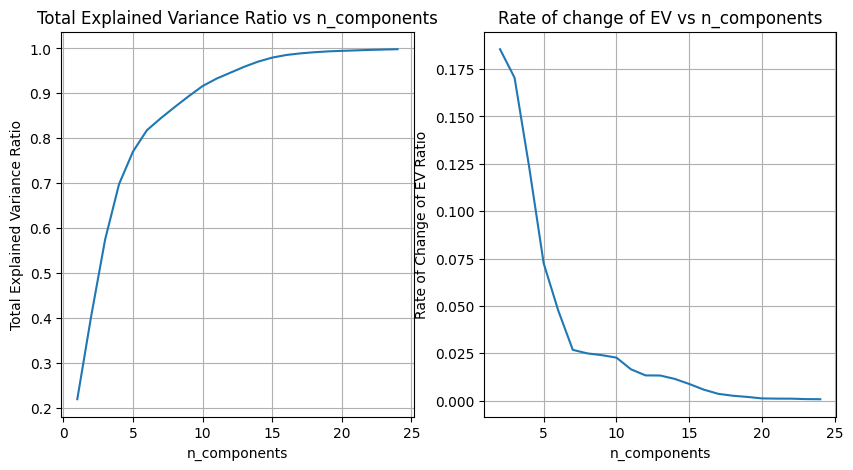

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

GLOBAL_RANDOM_STATE = 0


features = assembled_df.loc[:, assembled_df.columns != 'XNA_PRESENT']
labels = assembled_df['XNA_PRESENT']

scaler = StandardScaler()

scaled_features = features.copy()
scaled_features = pd.DataFrame(scaler.fit_transform(scaled_features))

component_list = list(np.arange(1,25, 1))
explained_variances = find_pca_components(component_list, scaled_features)

dy = np.diff(explained_variances)
dx = np.diff(component_list)

deriv = dy/dx
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(component_list, explained_variances)
ax[0].grid()
ax[0].set_title('Total Explained Variance Ratio vs n_components')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Total Explained Variance Ratio')
ax[1].plot(component_list[1:], dy/dx)
ax[1].grid()
ax[1].set_title('Rate of change of EV vs n_components')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('Rate of Change of EV Ratio')
print()

In [12]:
# Set up principal component analysis with 10 components, 
pca = PCA(n_components = 12, random_state=GLOBAL_RANDOM_STATE)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)
evrs = pca.explained_variance_ratio_

labels.reset_index(drop=True)
x_tr, x_te, y_tr, y_te = train_test_split(x_pca,
                                          labels,
                                          test_size=.3,
                                          random_state = GLOBAL_RANDOM_STATE)

print("Component Variance Ratio: ", evrs)
print("Total Explained Variance Ratio: ", evrs.sum())

Component Variance Ratio:  [0.21853789 0.1854632  0.17041675 0.12340891 0.07246101 0.04755431
 0.02679416 0.02493068 0.02398991 0.02268114 0.01650882 0.01331581]
Total Explained Variance Ratio:  0.946062603349194


In [14]:
# Set up device for pytorch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# Convert training data to tensors
tr_x_tensor = torch.tensor(x_tr).type(torch.float).to(device)
tr_y_tensor = torch.tensor(np.asarray(y_tr)).type(torch.LongTensor).to(device)

# Convert testing data to tensors
te_x_tensor = torch.tensor(x_te).type(torch.float).to(device)
te_y_tensor = torch.tensor(np.asarray(y_te)).type(torch.LongTensor).to(device)

# number of features
feature_num = tr_x_tensor.shape[1]

out_features = 2

epochs = 100

l_rate = .1

rs=42

neurons=10
layers = 3

loss_fxn = nn.CrossEntropyLoss()
actv_fxn = nn.ReLU()

PTmodel = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            neurons = neurons,
                            layers = layers,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)

PTmodel.train_model(tr_x_tensor, tr_y_tensor)
train_loss, train_acc = PTmodel.test_model(tr_x_tensor, tr_y_tensor)
test_loss, test_acc = PTmodel.test_model(te_x_tensor, te_y_tensor)

print("Training: {}, Testing: {}".format(train_acc, test_acc))

Training: 0.9917272329330444, Testing: 0.9942101240158081


In [34]:
import itertools

pytorch_params = {'device':[device],
                  'n_features':[feature_num],
                  'out_features':[out_features],
                  'neurons':[5, 10, 50, 100, 200],
                  'layers':[1, 5, 10, 20, 50],
                  'activation_function':[nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softmax()],
                  'loss_function':[nn.NLLLoss(),
                                   nn.CrossEntropyLoss()],
                  'n_epochs':[5, 10, 100, 1000],
                  'learning_rate':[.001, .01, 1],
                  'random_state':[rs]}

param_keys = list(pytorch_params.keys())
param_lists = []

for key in param_keys:
    value_list = pytorch_params[key]
    param_lists.append(value_list)
    
model_combos = list(itertools.product(*param_lists))

In [ ]:
results_dict = {}

# Iteration index for keeping progress
i = 0

# Loop through each possible combination of parameters.
for params in model_combos:
    
    # Print percentage progress
    print(percenttobar(i/len(model_combos)), end='\r')
    
    # Generate the model from the current parameters
    test_model = PyTorchClassifier(*params)
    
    # Here, we generate the key of the model based on it's params
    key = params
    
    # Train the model
    test_model.train_model(tr_x_tensor, tr_y_tensor)
    
    # Test the model on training and testing data
    train_loss, train_acc = test_model.test_model(tr_x_tensor, tr_y_tensor)
    test_loss, test_acc = test_model.test_model(te_x_tensor, te_y_tensor)
    
    # Return the results to the dictionary
    results_dict[key] = [train_acc, test_acc]
    
    # Incriment the progress tracker
    i+=1

In [ ]:
os.listdir("media/")